ν=20, ρ=0.1, PCT, alpha=0.005: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


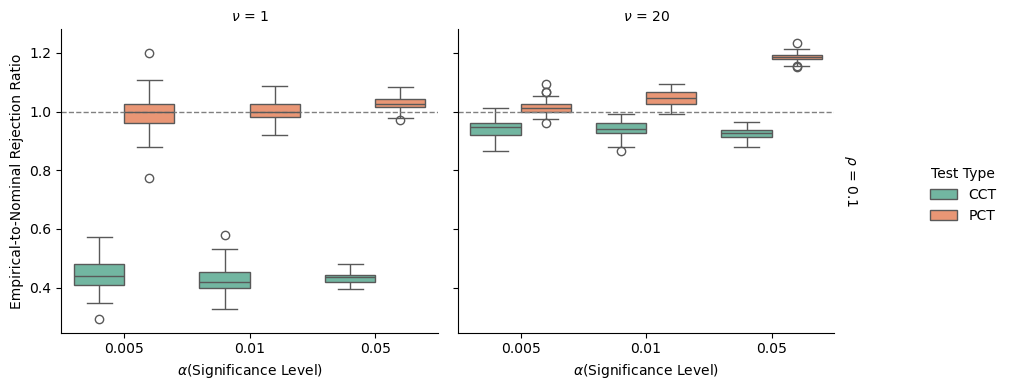

In [14]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from scipy.stats import cauchy,pareto
import random
import warnings
warnings.filterwarnings("ignore")
random.seed(42)

# Parameters
n_s = 100  
n = 15000
d = 5  
ws = np.ones(d)
ws = ws / np.sum(ws)  
nus = [1, 20]  # low, high df
rhos = [0.1]  
#t_pareto=[20,100,200] 
#t_cauchy=[np.tan(np.pi*(1/2-0.05)), np.tan(np.pi*(1/2-0.01)), np.tan(np.pi*(1/2-0.005))]
alphas=[0.05,0.01,0.005]

# For standard Cauchy: use inverse survival function (upper quantile)
t_cauchy = cauchy.isf(alphas)

# For standard Pareto with shape parameter alpha=1, scale=1
# Standard 1-Pareto: P(X > x) = 1/x, so X ~ Pareto(b=1, scale=1)
t_pareto = pareto.isf(alphas, b=1, scale=1)



def pareto_icdf(p):
    return 1 / (1 - p)  

def cauchy_icdf(p):
    return np.tan(np.pi * (p - 0.5))

def empirical_cauchy_scale(Y):
    n, d = Y.shape
    X = np.zeros_like(Y)
    for i in range(d):
        ranks = stats.rankdata(Y[:, i], method='ordinal')
        probs = ranks / (n + 1)
        X[:, i] = np.tan(np.pi * (probs - 0.5))
    return X

def empirical_pareto_scale(Y):
    n, d = Y.shape
    X = np.zeros_like(Y)
    for i in range(d):
        ranks = stats.rankdata(-Y[:, i], method='ordinal') 
        X[:, i] = (n + 1) / ranks
    return X

# Simulation storage
results = []

for nu in nus:
    for rho in rhos:
        # Create correlation matrix
        S=np.ones((d,d))
        S[:d//2,d//2:]=-1
        S[d//2:,:d//2]=-1
        Sigma = rho * S + (1 - rho) * np.eye(d)
        
        for test_type in ['CCT', 'PCT']:
            if test_type=='CCT': t_vals=t_cauchy
            else: t_vals=t_pareto
            for i in range(len(alphas)):
                ratios = []
                t=t_vals[i]
                for _ in tqdm(range(n_s), desc=f'ν={nu}, ρ={rho}, {test_type}, alpha={alphas[i]}'):
                    # Generate multivariate t samples: mean 0, scale Sigma, df=nu
                    z = np.random.multivariate_normal(np.zeros(d), Sigma, size=n)
                    chi2 = np.random.chisquare(nu, size=n).reshape(-1, 1)
                    t_samples = z / np.sqrt(chi2 / nu)

                    # Convert to p-values via t CDF (two-sided)
                    p_vals = 2 * (1 - stats.t.cdf(np.abs(t_samples), df=nu))

                    if test_type == 'CCT':
                        X = empirical_cauchy_scale(t_samples)
                    else:
                        X = empirical_pareto_scale(t_samples)

                    S = np.dot(X, ws)  
                    ratio = np.mean(S > t) / np.mean(X[:,0]>t)
                    ratios.append(ratio)

                for r in ratios:
                    results.append({
                        'ν': nu,
                        'ρ': rho,
                        'alpha': alphas[i],
                        'Test': test_type,
                        'Ratio': r
                    })

# Convert to DataFrame
df = pd.DataFrame(results)

# Plotting
g = sns.FacetGrid(df, row='ρ', col='ν', margin_titles=True, height=4, sharey=True)
g.map_dataframe(sns.boxplot, x='alpha', y='Ratio', hue='Test', palette='Set2')
for ax in g.axes.flatten():
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1)
g.set_axis_labels(r"$\alpha$(Significance Level)", "Empirical-to-Nominal Rejection Ratio")
g.set_titles(row_template=r"$\rho$ = {row_name}", col_template=r"$\nu$ = {col_name}")
g.add_legend(title='Test Type',  bbox_to_anchor=(1.05, 0.5), loc='center left')
#plt.suptitle("Asymptotic Calibration Comparison: PCT vs CCT", y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig("pct_vs_cct_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
